In [141]:
import os
import pandas as pd
import numpy as np
import matplotlib as pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split


In [4]:
column = ['userId','productId','Rating','timestamp']

In [14]:
df = pd.read_csv('/Users/praveenveera/GreatLearning/MyUniversity/Academic project/Recommendation System/ratings_Electronics.csv',names = column)

In [15]:
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [16]:
# Shape of the data
rows,columns = df.shape

In [17]:
print('Rows: {0}, Columns: {1} '.format(rows,columns))

Rows: 7824482, Columns: 4 


In [18]:
# 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
Rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


It looks like we have a dataset of 4 columns out of which 2 are object datatype. We may need to drill down and see what the data actually look like. 
Other two columns having one Float and one Int

In [19]:
# Check the Null values
df.isna().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

In [21]:
df['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [34]:
# No of users provided min rating
df['userId'][df.Rating == df['Rating'].min()].count()

901765

In [36]:
# No of users provided max rating
df['userId'][df.Rating == df['Rating'].max()].count()

4347541

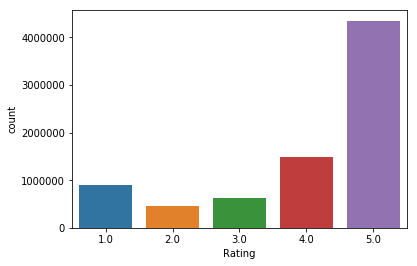

In [40]:
sns.countplot(df['Rating'])

In [124]:
top=df['userId'].value_counts()

In [129]:
top50 = top[top>=50]

In [131]:
df_ready= df[df.userId.isin(top50.index)]

In [133]:
df_ready.drop('timestamp',axis=1,inplace=True)

/Users/praveenveera/anaconda/envs/Python3_5/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [134]:
df_ready.head()

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [135]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
userId       125871 non-null object
productId    125871 non-null object
Rating       125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 8.8+ MB


In [137]:
# Calculate the density of the Rating Matrix

rating_matrix = df_ready.pivot(index='userId',columns = 'productId',values='Rating').fillna(0)

In [138]:
rating_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
rating_matrix.transpose().head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
train_data, test_data = train_test_split(df_ready, test_size = 0.3, random_state=0)

In [144]:
train_data.head()

,userId,productId,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [149]:
print(train_data.shape)
print(test_data.shape)

(88109, 3)
(37762, 3)


In [ ]:
# Build Popularity Recommender model

In [150]:
train_data.head()

,userId,productId,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [157]:
train_data_grouped = train_data.groupby('productId').agg({'userId':'count'}).reset_index()
train_data_grouped.rename(columns={'userId':'score'},inplace=True)

In [158]:
train_data_grouped.tail()

,productId,score
38221,B00LA6T0LS,2
38222,B00LBZ1Z7K,1
38223,B00LED02VY,1
38224,B00LGQ6HL8,3
38225,B00LI4ZZO8,1


In [163]:
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

In [165]:
train_data_sort['Rank']= train_data_sort['score'].rank(ascending=0, method='first') 

In [169]:
popularity_recommendations = train_data_sort.head()
popularity_recommendations

,productId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [180]:
# popularity_recommendations
def popularity_recommender(user_id):
    user_recommendations = popularity_recommendations
    user_recommendations['userId'] = user_id

    col = user_recommendations.columns.tolist()
    col = col[-1:] + col[:-1]
    user_recommendations = user_recommendations[col]
    return user_recommendations

In [182]:
popularity_recommender(1)

/Users/praveenveera/anaconda/envs/Python3_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,userId,productId,score,Rank
30847,1,B0088CJT4U,133,1.0
30287,1,B007WTAJTO,124,2.0
19647,1,B003ES5ZUU,122,3.0
8752,1,B000N99BBC,114,4.0
30555,1,B00829THK0,97,5.0


,productId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0
